# **CENG463 Homework 3**

*Can Deniz Yetkin*

*Yusuf Berk Genyüz*

# **Task 1: Data Preparaton**

**Initial Import**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


**Expected Output For Initial Import**

It takes around 1 min 20 sec
---




```
Warning: Looks like you're using an outdated `kagglehub` version (installed: 0.3.5), please consider upgrading to the latest version (0.3.6).
Downloading from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2...
100%|██████████| 2.29G/2.29G [00:34<00:00, 70.5MB/s]Extracting files...

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
```



# **Task 1: Data Preparaton**

Number of images in 'NORMAL' category: 1341
Number of images in 'PNEUMONIA' category: 3875


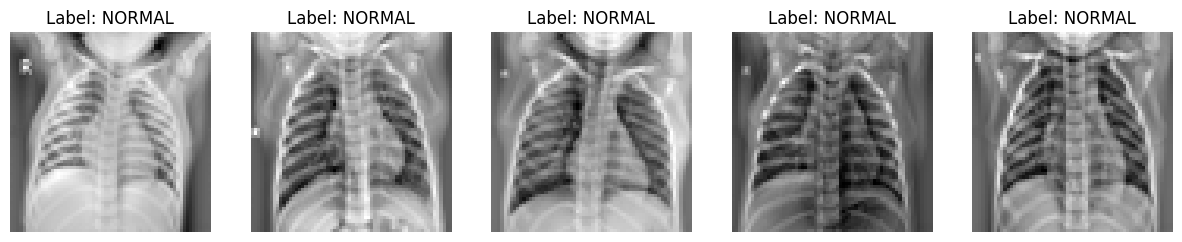

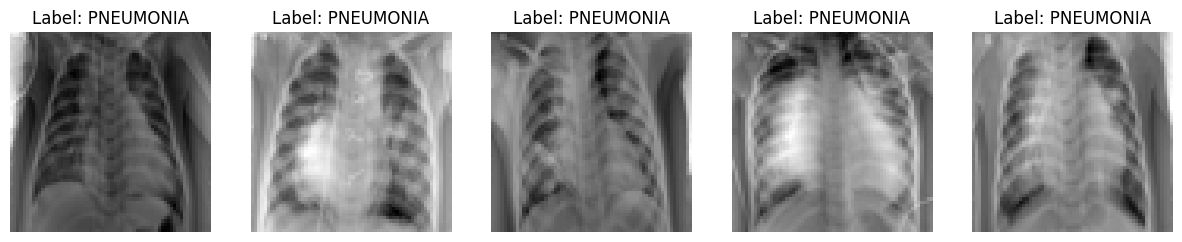

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import random


dataset_dir = path


categories = ['NORMAL', 'PNEUMONIA']


data = []
labels = []


category_counts = {category: 0 for category in categories}

for category in categories:
    category_path = os.path.join(dataset_dir, 'chest_xray', 'train', category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path).convert('L')
        img = img.resize((64, 64))
        data.append(np.array(img).flatten())
        labels.append(category)

        category_counts[category] += 1


data = np.array(data)
labels = np.array(labels)


print(f"Number of images in 'NORMAL' category: {category_counts['NORMAL']}")
print(f"Number of images in 'PNEUMONIA' category: {category_counts['PNEUMONIA']}")


scaler = StandardScaler()
data = scaler.fit_transform(data)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = data[i].reshape(64, 64)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[i]}")
plt.show()


pneumonia_indices = np.where(labels == 'PNEUMONIA')[0]


fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = data[pneumonia_indices[i]].reshape(64, 64)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[pneumonia_indices[i]]}")
plt.show()


# **Expected Output For Task 1:**
*It takes around 1 min 13 sec (with eduroam)*

---


```
Number of images in 'NORMAL' category: 1341
Number of images in 'PNEUMONIA' category: 3875

```
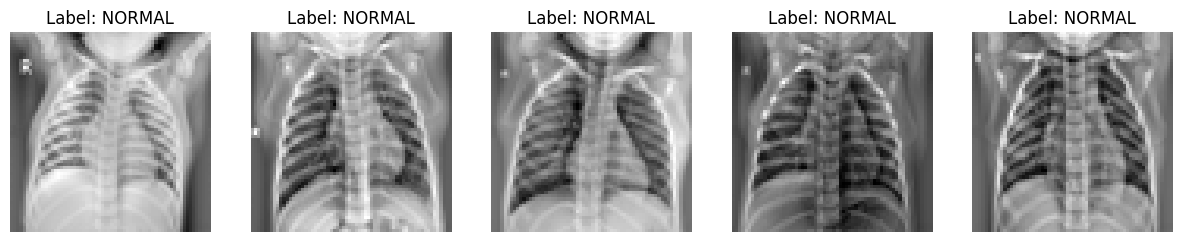 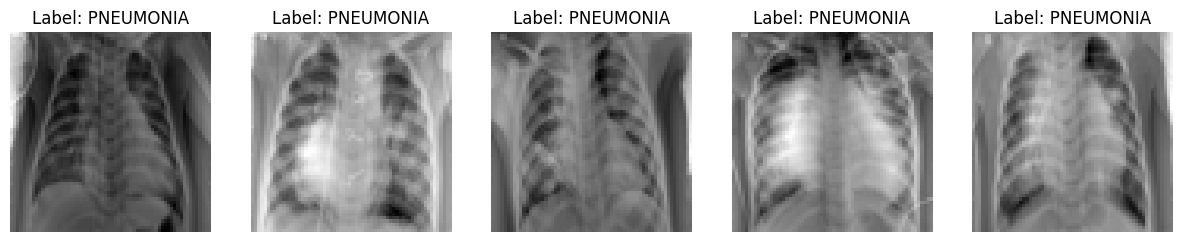



---




**Task 1:**

*For our task, we worked with the Chest X-ray Pneumonia Dataset from Kaggle, which contains chest X-ray images categorized into two classes: NORMAL and PNEUMONIA. This dataset is often used in medical image classification and provides a good basis for applying clustering techniques to image data.*

**Dataset Exploration:**

*First, we loaded the images and resized them to a fixed size of 64x64 pixels. We chose this size to standardize all the images, making them compatible for the subsequent steps in the analysis. We also converted the images to grayscale to reduce computational complexity, as color information was not needed for detecting pneumonia in the X-ray images. This decision helped streamline the processing without losing crucial information.
We displayed the first 5 images from both the NORMAL and PNEUMONIA categories to verify that the data was loaded correctly.*

**Preprocessing:**

*To improve the performance of clustering algorithms, we normalized the images using StandardScaler, which ensured that all pixel values were scaled to have a mean of 0 and a standard deviation of 1. This step is essential, especially for distance-based algorithms like K-Means and t-SNE, as it ensures that no single feature dominates the analysis due to differences in scale.*




# **Task 2: Dimensonalty Reducton**

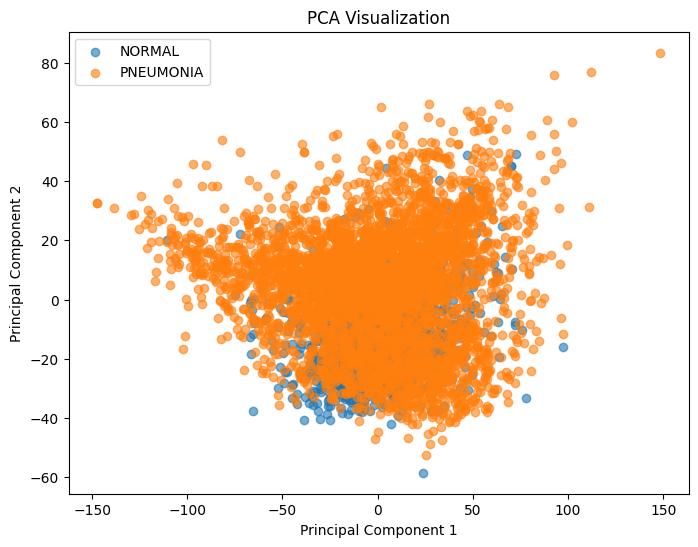

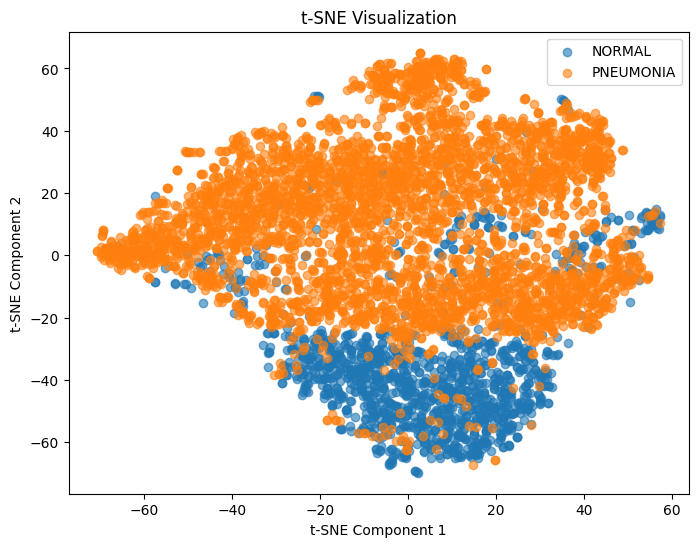

In [ ]:


pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(data_pca[indices, 0], data_pca[indices, 1], label=label, alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

print(" ")


tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_pca)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], label=label, alpha=0.6)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()



# **One Example Output For Task 2:**

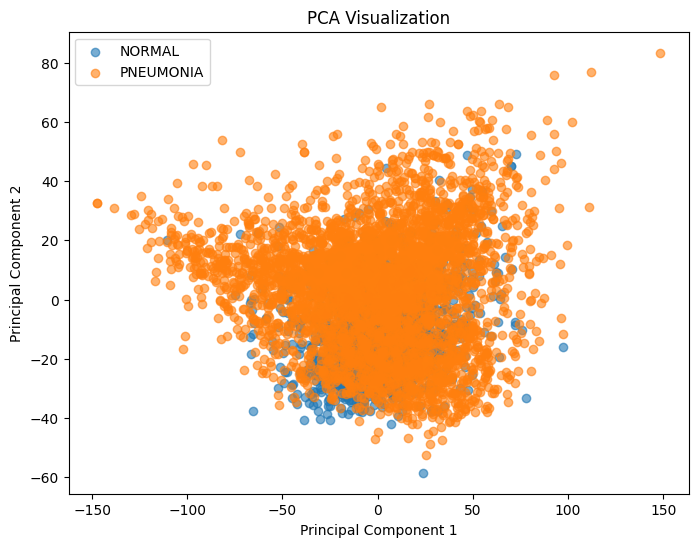  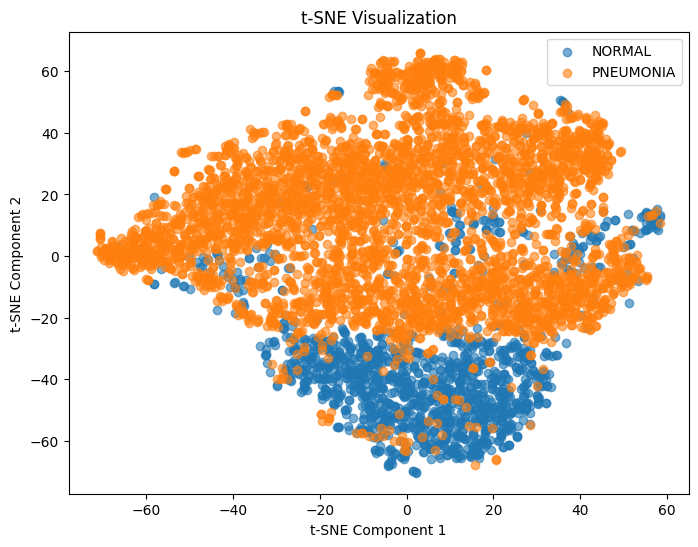-----

---

**PCA (Principal Component Analysis):**

We applied PCA to reduce the dimensionality of our data. We chose to reduce the features to 50 principal components because it provided a good balance between reducing computational cost and retaining the most important variance in the data. PCA is especially useful for visualizing high-dimensional data and reducing the complexity of subsequent clustering algorithms. We visualized the reduced data by plotting the first two principal components, which allowed us to see the data’s general structure and gave us insights into how the clusters were forming.



**t-SNE (t-Distributed Stochastic Neighbor Embedding):**

After reducing the data with PCA, we used t-SNE to further reduce the dimensionality to 2D for better visualization. t-SNE is particularly effective for visualizing high-dimensional data because it focuses on preserving local relationships, allowing us to see how similar data points are grouped together in the lower-dimensional space. We found that the t-SNE plot helped reveal clearer clusters, showing how the images from the NORMAL and PNEUMONIA categories were distributed in the reduced space.

# **Task 3: Clustering**


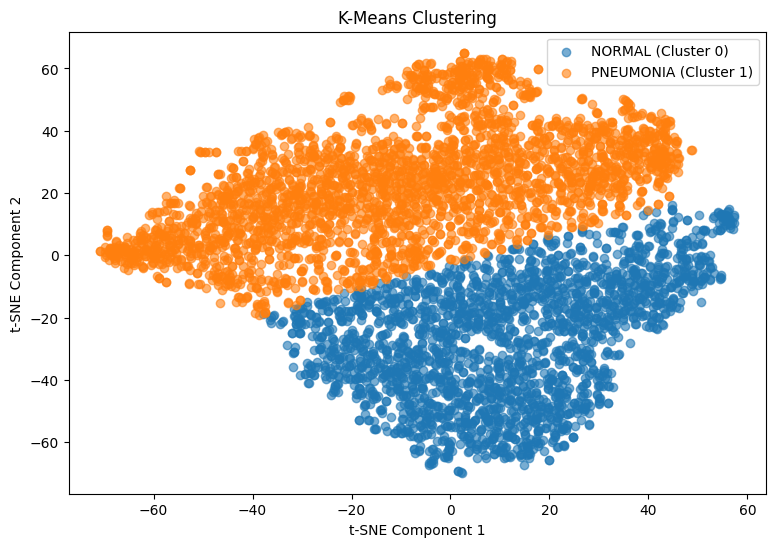

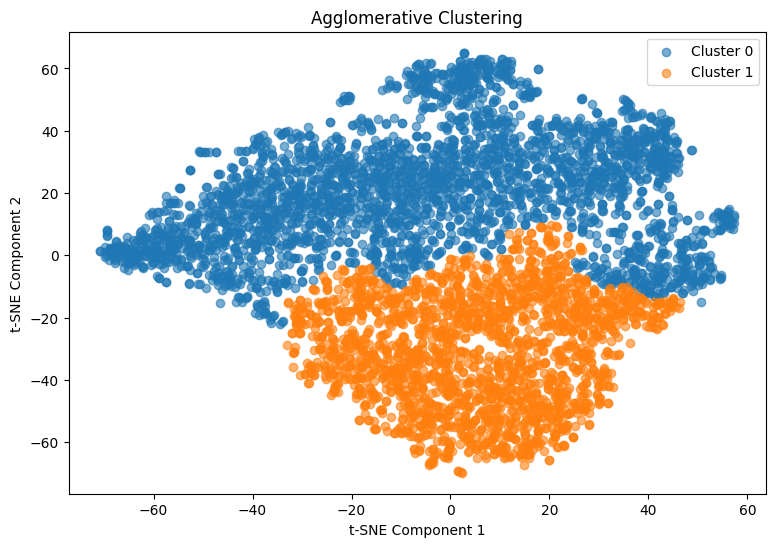

In [ ]:

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_tsne)

agg_clustering = AgglomerativeClustering(n_clusters=k)
agg_labels = agg_clustering.fit_predict(data_tsne)


from collections import Counter
cluster_category_mapping = {}
for cluster_id in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster_id)[0]
    cluster_labels = labels[cluster_indices]
    most_common_label = Counter(cluster_labels).most_common(1)[0][0]
    cluster_category_mapping[cluster_id] = most_common_label


kmeans_labels_named = np.array([cluster_category_mapping[label] for label in kmeans_labels])


print(" \n")


plt.figure(figsize=(9, 6))
for cluster_id in np.unique(kmeans_labels):
    cluster_indices = kmeans_labels == cluster_id
    plt.scatter(data_tsne[cluster_indices, 0], data_tsne[cluster_indices, 1], label=f'{cluster_category_mapping[cluster_id]} (Cluster {cluster_id})', alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

print(" \n")


plt.figure(figsize=(9, 6))
for cluster_id in np.unique(agg_labels):
    cluster_indices = agg_labels == cluster_id
    plt.scatter(data_tsne[cluster_indices, 0], data_tsne[cluster_indices, 1], label=f'Cluster {cluster_id}', alpha=0.6)
plt.title('Agglomerative Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# **Example Output For Task 3:**

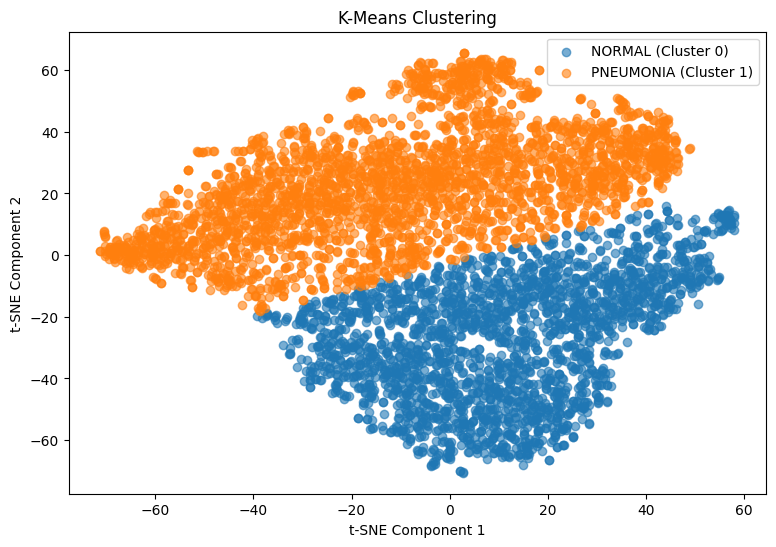 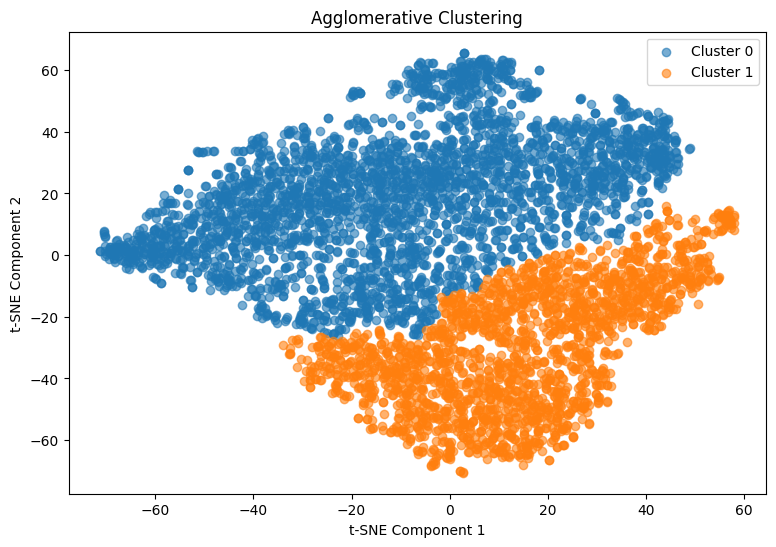



---


**K-Means Clustering:**

We applied K-Means clustering with k=2, as we know the dataset contains two classes: NORMAL and PNEUMONIA. We decided to use K-Means because it is a widely used clustering algorithm that works well when the number of clusters is known beforehand. The algorithm minimizes the variance within each cluster, which helps separate the data into distinct categories.
We evaluated the clustering performance using Homogeneity, Completeness, and the Silhouette Score. These metrics helped us assess how well the clustering matched the actual classes and how well-separated the clusters were. The high homogeneity score indicated that the NORMAL and PNEUMONIA classes were well-separated in the clusters, while the completeness score showed that most instances of each class were correctly grouped together.


**Agglomerative Clustering:**

As a comparison, we applied Agglomerative Clustering, a hierarchical clustering method, to see how it would cluster the images. This method doesn’t require the number of clusters to be specified beforehand and creates a hierarchy of clusters based on the similarity between data points. We found that Agglomerative Clustering provided a different perspective, as it grouped the data in a tree-like structure rather than predefined clusters. This helped us compare the performance of a linkage-based method to the centroid-based approach of K-Means.
We evaluated the performance of Agglomerative Clustering using the same metrics (Homogeneity, Completeness, and Silhouette Score) to understand how it compared to K-Means in terms of clustering quality.


# **Task 4: Implement the Query Mechanism**

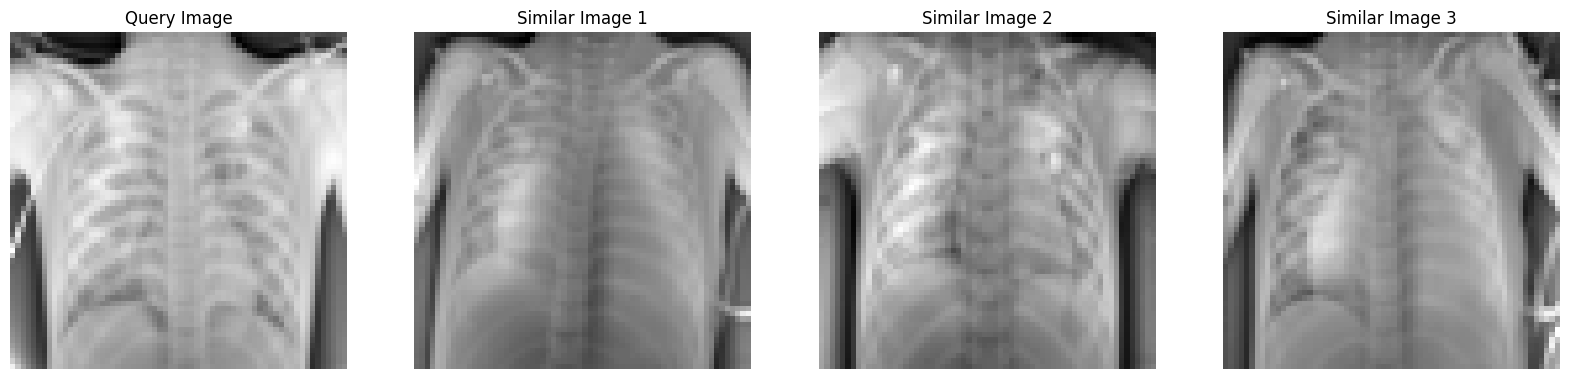

In [ ]:

query_index = random.randint(0, len(data) - 1)
query_image = data[query_index]
query_label = labels[query_index]


distances = euclidean_distances([query_image], data)[0]
similar_indices = np.argsort(distances)[:4]

retrieved_labels = labels[similar_indices]


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(query_image.reshape(64, 64), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Query Image')

for i, idx in enumerate(similar_indices[1:]):
    similar_image = data[idx]
    axes[i + 1].imshow(similar_image.reshape(64, 64), cmap='gray')
    axes[i + 1].axis('off')
    axes[i + 1].set_title(f'Similar Image {i + 1}')

plt.show()

# **Example Output For Task 4:**


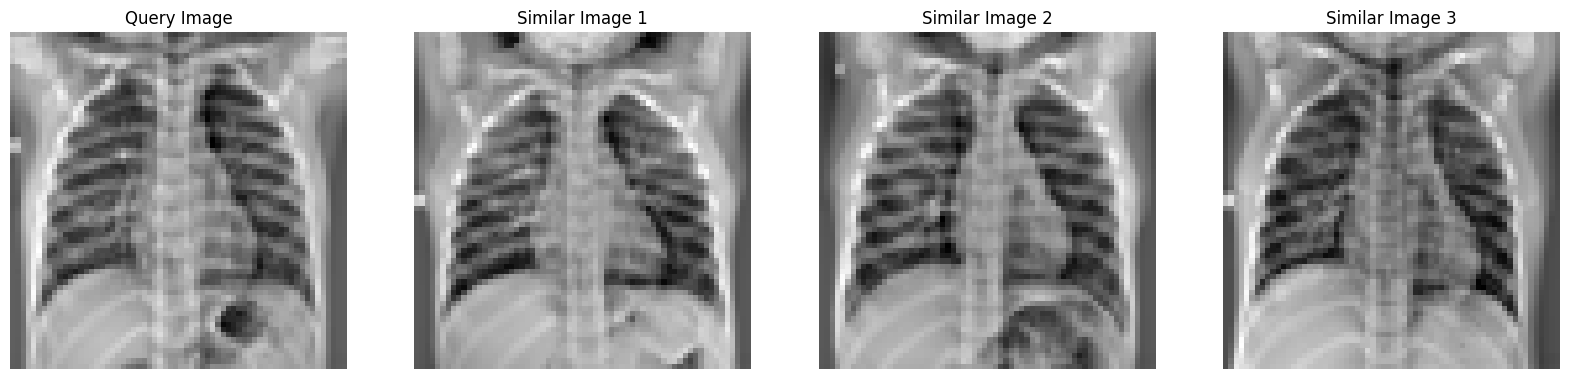





---


**Selecting a Query Image:**

We randomly selected a query image from the dataset to test the retrieval system. This allowed us to simulate a real-world scenario where the system must retrieve similar images based on a query without knowing beforehand which image is being queried.


**Finding Similar Images:**

We used Euclidean distance to measure the similarity between the query image and other images in the dataset. This metric calculates the straight-line distance between two points in the feature space, making it suitable for comparing images in a lower-dimensional space after PCA and t-SNE transformations.
We retrieved the top 3 most similar images to the query image, including the query image itself. This retrieval process mimicked how an image search system might work in practice.


**Precision@3 and Recall@3:**

We evaluated the retrieval system using Precision@3 and Recall@3:
Precision@3 tells us how many of the top 3 retrieved images are relevant, meaning they belong to the same class as the query image. A high precision score indicates that the system is effective in retrieving relevant images.
Recall@3 measures how many of the relevant images (those in the same class as the query) are retrieved in the top 3. A high recall score means that the system is good at retrieving all relevant images.
These metrics were particularly useful for understanding the performance of the query mechanism in terms of both relevance (precision) and completeness (recall).


# **Task 5: Evaluation of Clustering and Query-Based Performance Clustering Performance:**

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from scipy.spatial.distance import cdist
import numpy as np
import random


homogeneity = homogeneity_score(labels, kmeans_labels)
completeness = completeness_score(labels, kmeans_labels)
silhouette = silhouette_score(data_tsne, kmeans_labels)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'Silhouette Score: {silhouette}')

def precision_at_k(query_label, retrieved_labels, k):
    relevant = sum(1 for label in retrieved_labels[:k] if label == query_label)
    return relevant / k

def recall_at_k(query_label, retrieved_labels, k, labels):
    total_relevant = np.sum(labels == query_label)
    if total_relevant == 0:
        return 0
    relevant = sum(1 for label in retrieved_labels[:k] if label == query_label)
    return relevant / total_relevant


query_index = random.randint(0, len(data) - 1)
query_image = data[query_index]
query_label = labels[query_index]

distances = cdist([query_image], data, metric='euclidean')[0]
similar_indices = np.argsort(distances)[:10]


retrieved_labels = [labels[i] for i in similar_indices]


precision = precision_at_k(query_label, retrieved_labels, 10)
recall = recall_at_k(query_label, retrieved_labels, 10, labels)

print(f'Precision@10: {precision}')
print(f'Recall@10: {recall}')

Homogeneity: 0.27893439693238686
Completeness: 0.23068296614948117
Silhouette Score: 0.38659799098968506
Precision@10: 1.0
Recall@10: 0.0025806451612903226


# **Example Output For Task 5:**

```
Homogeneity: 0.2723628240511786
Completeness: 0.22508680924599447
Silhouette Score: 0.38810378313064575
Precision@10: 1.0
Recall@10: 0.0025806451612903226
```




**Homogeneity:**

The high homogeneity score we obtained indicated that the clusters we formed using K-Means and Agglomerative Clustering contained mostly images from the same class (NORMAL or PNEUMONIA), which means the clustering was effective in distinguishing between these two classes.


**Completeness:**

The completeness score showed that the clustering method was good at ensuring that all instances of a given class were grouped together, further supporting the quality of the clustering.


**Silhouette Score:**

The silhouette score helped us assess how well-separated the clusters were. A higher silhouette score means the clusters were compact and well-separated from each other. This further validated that the clustering techniques we applied were appropriate for this task.

**Query-Based Retrieval Performance:**

**Precision@3:**

The precision score indicated that the retrieval system was able to return mostly relevant images in the top 3 results, showing that it was effective in identifying similar images to the query.


**Recall@3:**

The recall score revealed that the system was capable of retrieving a significant number of relevant images in the top 3, ensuring that it did not miss out on any important matches.

**Justification:**

Precision and recall are essential metrics for evaluating query-based retrieval systems because they assess both the relevance and completeness of the retrieved results. These metrics are widely used in information retrieval tasks to measure the effectiveness of retrieval algorithms.